# Sentiment Analysis
We will develop multiple sentiment classifiers for a movie review dataset and then we will predict the number of positive and negative reviews based on a test set. For each classifier we set and tune the hyper-parameters. Then, we will calculate the precision, recall, F1, precision-recall AUC scores and their learning curves. 
### 2nd Assignment


---
 >Panagiotis Giannopoulos, P3352102 <br />
 >MSc in Data Science <br />
 >Athens University of Economics and Business <br />
 pgiannopoulos@aueb.gr

**Install required packages**

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install kaggle

## Dataset
For the scope of our analysis we use the IMDB Dataset of 50K Movie Reviews from Kaggle. <br>
* https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

IMDB dataset has 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. The dataset provides a set of 25,000 positive movie reviews and 25,000 negative movie reviews. So, we can predict the number of positive and negative reviews using either classification or deep learning algorithms. 

#### **Download and import the dataset**

In [ ]:
#Mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Configure Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

#Move to Kaggle directory
%cd /content/drive/My Drive/Kaggle/

#Download Dataset
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

/content/drive/My Drive/Kaggle
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


**Import the dataset**

In [ ]:
import pandas as pd
import numpy as np

#Importing the dataset

imdb_data=pd.read_csv('/content/drive/My Drive/Text Analytics/2nd Assignment/IMDB Dataset.csv', encoding='utf-8')
print("Dimensions of the dataset: ", imdb_data.shape, '\n')
imdb_data.head(10)

Dimensions of the dataset:  (50000, 2) 



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


####  **Preprocess dataset**
We begin the cleaning by dropping the duplicate values, then we clean the text from HTML marks and others pecularities. Then we tokenize the dataset and lemmatize it. After the above jobs we join the tokens again and reconstruct the dataset. 

At the end we use the Label Binezer one hot encoding the sentiment values. 
* Positive:  1
* Negative: 0 

**Drop duplicate values**

In [ ]:
#Drop duplicate values
imdb_data = imdb_data.drop_duplicates(subset = ['review'])

#Sentiment count
imdb_data['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

**Cleaning the dataset**

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from nltk.stem import WordNetLemmatizer

# Copy and create the new dataset
imdb_data_new = imdb_data[['review','sentiment']].copy()

#Remove html noise (like <br />)
imdb_data_new['review'] = [re.sub(r'<.*?>', ' ', str(x)) for x in imdb_data_new['review']]

#Remove non-word (special) characters such as punctuation, numbers etc
imdb_data_new['review'] = [re.sub(r'\W', ' ', str(x)) for x in imdb_data_new['review']]

#Remove all single characters
imdb_data_new['review'] = [re.sub(r'\s+[a-zA-Z]\s+', ' ', str(x)) for x in imdb_data_new['review']]

#Substitute multiple spaces with single space
imdb_data_new['review'] = [re.sub(r'\s+', ' ', str(x), flags=re.I) for x in imdb_data_new['review']]

#Convert to lowercase
imdb_data_new['review'] = imdb_data_new['review'].str.lower()

**Tokenize the sentences and lemmatize the words**

In [ ]:
# Split the document based on whitespaces (--> List of words) & Lemmatization

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

imdb_data_new['review'] = imdb_data_new.review.apply(lemmatize_text)

# Reconstruct the document by joining the words on each whitespace
imdb_data_new['review'] = [' '.join(x) for x in imdb_data_new['review']]

**One hot enconding sentiment values**

In [ ]:
from sklearn.preprocessing import LabelBinarizer
#where it is positive-> 1 , negative->0

#Labeling the sentiment data
lb=LabelBinarizer()
#Transformed sentiment data (positive:1, negative:0)
imdb_data_new['sentiment'] = lb.fit_transform(imdb_data_new['sentiment'])
imdb_data_new

,review,sentiment
0,one of the other reviewer ha mentioned that af...,1
1,a wonderful little production the filming tech...,1
2,i thought this wa wonderful way to spend time ...,1
3,basically there a family where little boy jake...,0
4,petter mattei love in the time of money is vis...,1
...,...,...
49995,i thought this movie did down right good job i...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am catholic taught in parochial elementary s...,0
49998,i going to have to disagree with the previous ...,0


### **Split dataset**
We split the dataset in 
* Train (70%)
* Development (15%) 
* Test (15%)

We separate the data as training set and development set to increase reliability. We will train our models with the training dataset and evaluate with the development data and after determining the most suitable hyperparameters for the model, apply it to the test dataset.

In [ ]:
from sklearn.model_selection import train_test_split  

x_traindev, x_test, y_traindev, y_test = train_test_split(imdb_data_new.review, imdb_data_new.sentiment, test_size=0.15, random_state=23828748)
x_train, x_dev, y_train, y_dev = train_test_split(x_traindev, y_traindev, test_size=0.1765, random_state=23828748)

In [ ]:
print('Training set    : ', len(x_train))
print('Development set : ', len(x_dev))
print('Test set        : ', len(x_test))

Training set    :  34705
Development set :  7439
Test set        :  7438


## **Feature extraction (Tf-IDF n-gram features)**

We decide to use the Tf-IDF method to exctract features from our dataset. Then, after we extract the features for all the three of our subsets we decide to use two approachs which ones we will use. <br>
* **Select K best features with chi2 scores**
* **Dimensionality reduction on the features** 


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Exclude stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range = (1, 2), 
    sublinear_tf = True, 
    stop_words = stopwords.words('english'))

# Fit Vectorizer on train data
# Transform on all data (train - development - test)
x_traindev_tfidf = vectorizer.fit_transform(x_traindev)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_dev_tfidf = vectorizer.transform(x_dev)
x_test_tfidf = vectorizer.transform(x_test)

print('\nShape of training data:    {}'.format(x_train_tfidf.shape))
print('Shape of development data: {}'.format(x_dev_tfidf.shape))
print('Shape of test data:        {}\n'.format(x_test_tfidf.shape))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

Shape of training data:    (34705, 2259006)
Shape of development data: (7439, 649121)
Shape of test data:        (7438, 649121)



#### **Feature selection (Select K best)**

SelectKBest function is used for selecting the K number of top features based on the Chi-square score. The Chi-square test is used in statistics to test the independence of two events. More specifically in feature selection, we use it to test whether the occurrence of a specific term and the occurrence of a specific class are independent. 

We decide to keep the ***7000*** best features based on the above approach.

In [ ]:
https://medium.com/analytics-vidhya/the-best-feature-selection-technique-for-text-classification-23199b4a4f8d

from sklearn.feature_selection import SelectKBest, chi2

# The function relies on nonparametric methods 
x_traindev_kbest = SelectKBest(score_func=chi2, k=7000).fit_transform(x_traindev_tfidf, y_traindev)
x_train_kbest = SelectKBest(score_func=chi2, k=7000).fit_transform(x_train_tfidf, y_train)
x_dev_kbest = SelectKBest(score_func=chi2, k=7000).transform(x_dev_tfidf, y_dev)
x_test_kbest = SelectKBest(score_func=chi2, k=7000).transform(x_test_tfidf, y_test)

print('Shape of training data:    {} --> {}'.format(x_train_tfidf.shape, x_train_kbest.shape))
print('Shape of development data: {} --> {}'.format(x_dev_tfidf.shape, x_dev_kbest.shape))
print('Shape of testing data:     {} --> {}'.format(x_test_tfidf.shape, x_test_kbest.shape))

#### **Dimensionality reduction (SVD)**

Except from the above dataset we will use in our model a second approach with dimension reduction in our features. We will use the SVD method and we will keep ***100*** components.

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=100, random_state=4321) 

x_traindev_svd = svd.fit_transform(x_traindev_tfidf)
x_train_svd = svd.fit_transform(x_train_tfidf)
x_dev_svd = svd.transform(x_dev_tfidf)
x_test_svd = svd.transform(x_test_tfidf)

print('Shape of training data:    {} --> {}'.format(x_train_tfidf.shape, x_train_svd.shape))
print('Shape of development data: {} --> {}'.format(x_dev_tfidf.shape, x_dev_svd.shape))
print('Shape of testing data:     {} --> {}'.format(x_test_tfidf.shape, x_test_svd.shape))

Shape of training data:    (34705, 2259006) --> (34705, 100)
Shape of development data: (7439, 649121) --> (7439, 100)
Shape of testing data:     (7438, 649121) --> (7438, 100)


## **Classifiers**

In our sentiment analysis we will create and compare three classifiers in our two datasets:

* Logistic Regression Classifier
* Naive Bayes Classifier
* KNN Classifier

In total we will have six cases.bold text 

#### **Baseline**

Before we start creating our models, we will produce as a baseline a Dummy Classifier to test initialy our results.

Training took: 0.002785921096801758 seconds 

Train accuracy: 50.15%
Development accuracy: 51.16% 
Test accuracy: 49.38% 

#Class 0 in Train dataset: (17300,)
#Class 1 in Train dataset: (17405,) 



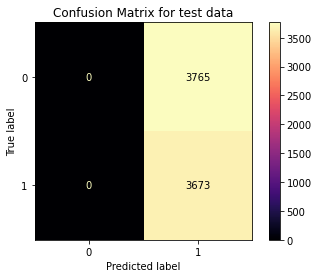

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = baseline.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_dev = baseline.predict(x_dev_tfidf)
score = accuracy_score(y_dev, predictions_dev)
print("Development accuracy: {:.2f}% ".format(score*100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape,'\n')

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(baseline, x_test_tfidf, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

### **Logistic Regression**

First, we will perform hyperparameter tuning in our training data through the function RandomizedSearchCV. Then, we will evaluate the results in our development subset and we will perform the fitting with the best parameters in both training and development subset. Finally we will evaluate our results in our three subsets.

#### **Dataset (Select K-best)**

First we will use the (Select K-best) dataset for our classifier.

**Create and Tuning Classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression()

grid_params = {
  'solver': ['liblinear'],
  'C': np.linspace(0.1, 1, 10),
  'max_iter': [50, 100, 200],
}

# Train
# Solver -- Algorithm to use in the optimization problem.
clf = RandomizedSearchCV(model, grid_params, scoring='f1', n_jobs=-1, n_iter=100)
start_time = time.time()
clf.fit(x_train_kbest, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate in development data
val_score=clf.score(x_dev_kbest, y_dev)

print("Validation Score: {:.4f}".format(val_score))
print("Best Score: {:.4f}".format(clf.best_score_),'\n')
print("Best Parameters: ", clf.best_params_)

Training took: 40.558266401290894 seconds 

Validation Score: 0.6674
Best Score: 0.8852 

Best Parameters:  {'solver': 'liblinear', 'max_iter': 50, 'C': 1.0}


**Evaluate Classifier**

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')

### Create classifier that fits in train and development data ###
clf_lr_kbest = LogisticRegression(**clf.best_params_).fit(x_traindev_kbest, y_traindev)


###### Evaluate ######

# Training Data
predictions = clf_lr_kbest.predict(x_train_kbest)
report_training = classification_report(y_train, predictions, target_names=['Negative','Positive'])
print("--------------------Training Data--------------------")
print(report_training)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_train, clf_lr_kbest.predict_proba(x_train_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_train, clf_lr_kbest.predict_proba(x_train_kbest)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_train, clf_lr_kbest.predict(x_train_kbest))),'\n')

# Developmnent Data
predictions_dev = clf_lr_kbest.predict(x_dev_kbest)
report_dev = classification_report(y_dev, predictions_dev, target_names=['Negative','Positive'])
print("-------------------Development Data-------------------")
print(report_dev)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_dev, clf_lr_kbest.predict_proba(x_dev_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_dev, clf_lr_kbest.predict_proba(x_dev_kbest)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_dev, clf_lr_kbest.predict(x_dev_kbest))),'\n')

--------------------Training Data--------------------
              precision    recall  f1-score   support

    Negative       0.74      0.43      0.54     17300
    Positive       0.60      0.85      0.70     17405

    accuracy                           0.64     34705
   macro avg       0.67      0.64      0.62     34705
weighted avg       0.67      0.64      0.62     34705

PR-AUC score Negative: 0.2907
PR-AUC score Positive: 0.7093 

Macro average PR-AUC score: 0.5840 

-------------------Development Data-------------------
              precision    recall  f1-score   support

    Negative       0.55      0.53      0.54      3633
    Positive       0.56      0.58      0.57      3806

    accuracy                           0.55      7439
   macro avg       0.55      0.55      0.55      7439
weighted avg       0.55      0.55      0.55      7439

PR-AUC score Negative: 0.4209
PR-AUC score Positive: 0.5791 

Macro average PR-AUC score: 0.5415 



**Testing Classifier**

----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative       0.63      0.46      0.53      3765
    Positive       0.57      0.73      0.64      3673

    accuracy                           0.59      7438
   macro avg       0.60      0.59      0.58      7438
weighted avg       0.60      0.59      0.58      7438

PR-AUC score Negative: 0.3670
PR-AUC score Positive: 0.6330 

Macro average PR-AUC score: 0.5465 



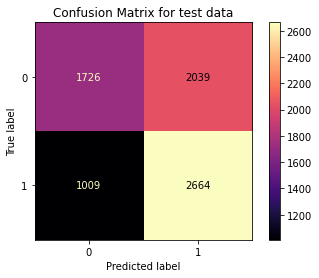

In [ ]:
# Testing data
predictions_test = clf_lr_kbest.predict(x_test_kbest)
report_test = classification_report(y_test, predictions_test, target_names=['Negative','Positive'])
print("----------------------Test Data----------------------")
print(report_test)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_test, clf_lr_kbest.predict_proba(x_test_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_test, clf_lr_kbest.predict_proba(x_test_kbest)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_test, clf_lr_kbest.predict(x_test_kbest))),'\n')

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf_lr_kbest, x_test_kbest, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

#### **Dataset (Dimensionality Reduction)**
Then we will use the (Dimensionality reduction) dataset for our classifier.

**Create and Tuning Classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

model = LogisticRegression()

grid_params = {
  'solver': ['liblinear'],
  'C': np.linspace(0.1, 1, 10),
  'max_iter': [50, 100, 200],
}

# Train
# Solver -- Algorithm to use in the optimization problem.
clf = RandomizedSearchCV(model, grid_params, scoring='f1', n_jobs=-1, n_iter=100)
start_time = time.time()
clf.fit(x_train_svd, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate in development data
val_score=clf.score(x_dev_svd, y_dev)

print("Validation Score: {:.4f}".format(val_score))
print("Best Score: {:.4f}".format(clf.best_score_),'\n')
print("Best Parameters: ", clf.best_params_)

Training took: 54.58401584625244 seconds 

Validation Score: 0.7557
Best Score: 0.8723 

Best Parameters:  {'solver': 'liblinear', 'max_iter': 50, 'C': 1.0}


**Evaluate Classifier**

In [ ]:
# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')

### Create classifier that fits in train and development data ###
clf_lr_svd_est = LogisticRegression(**clf.best_params_)
clf_lr_svd = LogisticRegression(**clf.best_params_).fit(x_traindev_svd, y_traindev)


##### Evaluate #####

# Training Data
predictions = clf_lr_svd.predict(x_train_svd)
report_training = classification_report(y_train, predictions, target_names=['Negative','Positive'])
print("--------------------Training Data--------------------")
print(report_training)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_train, clf_lr_svd.predict_proba(x_train_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_train, clf_lr_svd.predict_proba(x_train_svd)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_train, clf_lr_svd.predict(x_train_svd))),'\n')

# Developmnent Data
predictions_dev = clf_lr_svd.predict(x_dev_svd)
report_dev = classification_report(y_dev, predictions_dev, target_names=['Negative','Positive'])
print("-------------------Development Data-------------------")
print(report_dev)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_dev, clf_lr_svd.predict_proba(x_dev_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_dev, clf_lr_svd.predict_proba(x_dev_svd)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_dev, clf_lr_svd.predict(x_dev_svd))),'\n')

--------------------Training Data--------------------
              precision    recall  f1-score   support

    Negative       0.85      0.80      0.83     17300
    Positive       0.81      0.86      0.84     17405

    accuracy                           0.83     34705
   macro avg       0.83      0.83      0.83     34705
weighted avg       0.83      0.83      0.83     34705

PR-AUC score Negative: 0.0862
PR-AUC score Positive: 0.9138 

Macro average PR-AUC score: 0.7717 

-------------------Development Data-------------------
              precision    recall  f1-score   support

    Negative       0.75      0.75      0.75      3633
    Positive       0.76      0.76      0.76      3806

    accuracy                           0.75      7439
   macro avg       0.75      0.75      0.75      7439
weighted avg       0.75      0.75      0.75      7439

PR-AUC score Negative: 0.1719
PR-AUC score Positive: 0.8281 

Macro average PR-AUC score: 0.6976 



**Testing Classifier**

----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative       0.76      0.75      0.76      3765
    Positive       0.75      0.76      0.75      3673

    accuracy                           0.75      7438
   macro avg       0.75      0.75      0.75      7438
weighted avg       0.75      0.75      0.75      7438

PR-AUC score Negative: 0.1650
PR-AUC score Positive: 0.8350 

Macro average PR-AUC score: 0.6870 



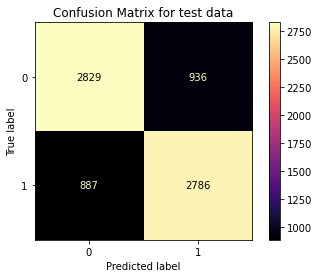

In [ ]:
# Testing data
predictions_test = clf_lr_svd.predict(x_test_svd)
report_test = classification_report(y_test, predictions_test, target_names=['Negative','Positive'])
print("----------------------Test Data----------------------")
print(report_test)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_test, clf_lr_svd.predict_proba(x_test_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_test, clf_lr_svd.predict_proba(x_test_svd)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_test, clf_lr_svd.predict(x_test_svd))),'\n')

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf_lr_svd, x_test_svd, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

### **Naive Bayes**

We will use the same approach as above for the process to determine the classifier.

#### **Dataset (Select K-best)**

First we will use the (Select K-best) dataset for our classifier.

**Create and Tuning Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

model = MultinomialNB()

grid_params = {
'alpha': (10, 1, 0.1, 0.01, 0.001),
'fit_prior': (True, False),
}

# Train
# Solver -- Algorithm to use in the optimization problem.
clf = RandomizedSearchCV(model, grid_params, scoring='f1', n_jobs=-1, n_iter=100)
start_time = time.time()
clf.fit(x_train_kbest, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate in development data
val_score=clf.score(x_dev_kbest, y_dev)

print("Validation Score: {:.4f}".format(val_score))
print("Best Score: {:.4f}".format(clf.best_score_),'\n')
print("Best Parameters: ", clf.best_params_)

Training took: 6.392175912857056 seconds 

Validation Score: 0.4917
Best Score: 0.9079 

Best Parameters:  {'fit_prior': True, 'alpha': 0.01}


**Evaluate Classifier**

In [ ]:
# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')

### Create classifier that fits in train and development data ###
clf_nb_kbest = MultinomialNB(**clf.best_params_).fit(x_traindev_kbest, y_traindev)

##### Evaluate #####

# Training Data
predictions = clf_nb_kbest.predict(x_train_kbest)
report_training = classification_report(y_train, predictions, target_names=['Negative','Positive'])
print("--------------------Training Data--------------------")
print(report_training)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_train, clf_nb_kbest.predict_proba(x_train_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_train, clf_nb_kbest.predict_proba(x_train_kbest)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_train, clf_nb_kbest.predict(x_train_kbest))),'\n')

# Developmnent Data
predictions_dev = clf_nb_kbest.predict(x_dev_kbest)
report_dev = classification_report(y_dev, predictions_dev, target_names=['Negative','Positive'])
print("-------------------Development Data-------------------")
print(report_dev)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_dev, clf_nb_kbest.predict_proba(x_dev_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_dev, clf_nb_kbest.predict_proba(x_dev_kbest)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_dev, clf_nb_kbest.predict(x_dev_kbest))),'\n')

--------------------Training Data--------------------
              precision    recall  f1-score   support

    Negative       0.62      0.76      0.68     17300
    Positive       0.69      0.53      0.60     17405

    accuracy                           0.65     34705
   macro avg       0.65      0.65      0.64     34705
weighted avg       0.65      0.65      0.64     34705

PR-AUC score Negative: 0.2791
PR-AUC score Positive: 0.7209 

Macro average PR-AUC score: 0.6013 

-------------------Development Data-------------------
              precision    recall  f1-score   support

    Negative       0.51      0.74      0.60      3633
    Positive       0.57      0.33      0.42      3806

    accuracy                           0.53      7439
   macro avg       0.54      0.53      0.51      7439
weighted avg       0.54      0.53      0.51      7439

PR-AUC score Negative: 0.4271
PR-AUC score Positive: 0.5729 

Macro average PR-AUC score: 0.5302 



**Testing Classifier**

----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative       0.59      0.81      0.68      3765
    Positive       0.69      0.43      0.53      3673

    accuracy                           0.62      7438
   macro avg       0.64      0.62      0.61      7438
weighted avg       0.64      0.62      0.61      7438

PR-AUC score Negative: 0.3008
PR-AUC score Positive: 0.6992 

Macro average PR-AUC score: 0.5776 



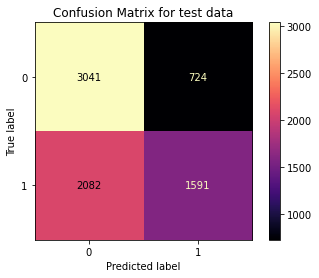

In [ ]:
# Testing data
predictions_test = clf_nb_kbest.predict(x_test_kbest)
report_test = classification_report(y_test, predictions_test, target_names=['Negative','Positive'])
print("----------------------Test Data----------------------")
print(report_test)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_test, clf_nb_kbest.predict_proba(x_test_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_test, clf_nb_kbest.predict_proba(x_test_kbest)[:, 1])),'\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_test, clf_nb_kbest.predict(x_test_kbest))), '\n')

# Plot Confusion Matrix

ConfusionMatrixDisplay.from_estimator(clf_nb_kbest, x_test_kbest, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

#### **Dataset (Dimensionality Reduction)**
Then we will use the (Dimensionality reduction) dataset for our classifier. Because NB can't receive negative values we will use the function MinMaxScaler to tranform our data.

**Create and Tuning Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

#https://stackoverflow.com/questions/24169238/dealing-with-negative-values-in-sklearn-multinomialnb
scaler = MinMaxScaler()
x_traindev_svd_sc = scaler.fit_transform(x_traindev_svd)
x_train_svd_sc = scaler.fit_transform(x_train_svd)
x_dev_svd_sc = scaler.transform(x_dev_svd)
x_test_svd_sc = scaler.transform(x_test_svd)

model = MultinomialNB()

grid_params = {
'alpha': (1, 0.1, 0.01, 0.001),
'fit_prior': (True, False),
}

# Train
# Solver -- Algorithm to use in the optimization problem.
clf = RandomizedSearchCV(model, grid_params, scoring='f1', n_jobs=-1, n_iter=100)
start_time = time.time()
clf.fit(x_train_svd_sc, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate in development data
val_score=clf.score(x_dev_svd_sc, y_dev)

print("Validation Score: {:.4f}".format(val_score))
print("Best Score: {:.4f}".format(clf.best_score_),'\n')
print("Best Parameters: ", clf.best_params_)

Training took: 5.274194955825806 seconds 

Validation Score: 0.6935
Best Score: 0.8415 

Best Parameters:  {'fit_prior': False, 'alpha': 0.01}


**Evaluate Classifier**

In [ ]:
# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')

### Create classifier that fits in train and development data ###
clf_nb_svd_est = MultinomialNB(**clf.best_params_)
clf_nb_svd = MultinomialNB(**clf.best_params_).fit(x_traindev_svd_sc, y_traindev)

##### Evaluate #####

# Training Data
predictions = clf_nb_svd.predict(x_train_svd_sc)
report_training = classification_report(y_train, predictions, target_names=['Negative','Positive'])
print("--------------------Training Data--------------------")
print(report_training)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_train, clf_nb_svd.predict_proba(x_train_svd_sc)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_train, clf_nb_svd.predict_proba(x_train_svd_sc)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_train, clf_nb_svd.predict(x_train_svd_sc))), '\n')

# Developmnent Data
predictions_dev = clf_nb_svd.predict(x_dev_svd_sc)
report_dev = classification_report(y_dev, predictions_dev, target_names=['Negative','Positive'])
print("-------------------Development Data-------------------")
print(report_dev)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_dev, clf_nb_svd.predict_proba(x_dev_svd_sc)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_dev, clf_nb_svd.predict_proba(x_dev_svd_sc)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_dev, clf_nb_svd.predict(x_dev_svd_sc))), '\n')

--------------------Training Data--------------------
              precision    recall  f1-score   support

    Negative       0.84      0.75      0.79     17300
    Positive       0.77      0.86      0.82     17405

    accuracy                           0.81     34705
   macro avg       0.81      0.81      0.80     34705
weighted avg       0.81      0.81      0.80     34705

PR-AUC score Negative: 0.1105
PR-AUC score Positive: 0.8895 

Macro average PR-AUC score: 0.7371 

-------------------Development Data-------------------
              precision    recall  f1-score   support

    Negative       0.67      0.81      0.74      3633
    Positive       0.78      0.62      0.69      3806

    accuracy                           0.72      7439
   macro avg       0.73      0.72      0.71      7439
weighted avg       0.73      0.72      0.71      7439

PR-AUC score Negative: 0.1925
PR-AUC score Positive: 0.8075 

Macro average PR-AUC score: 0.6778 



**Testing Classifier**

----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative       0.70      0.82      0.76      3765
    Positive       0.78      0.65      0.71      3673

    accuracy                           0.74      7438
   macro avg       0.74      0.73      0.73      7438
weighted avg       0.74      0.74      0.73      7438

PR-AUC score Negative: 0.1709
PR-AUC score Positive: 0.8291 

Macro average PR-AUC score: 0.6785 



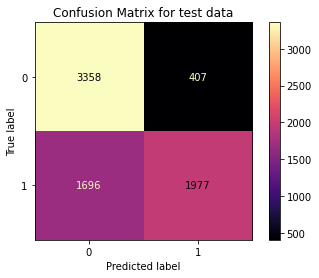

In [ ]:
# Test data
predictions_test = clf_nb_svd.predict(x_test_svd_sc)
report_test = classification_report(y_test, predictions_test, target_names=['Negative','Positive'])
print("----------------------Test Data----------------------")
print(report_test)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_test, clf_nb_svd.predict_proba(x_test_svd_sc)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_test, clf_nb_svd.predict_proba(x_test_svd_sc)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_test, clf_nb_svd.predict(x_test_svd_sc))), '\n')

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf_nb_svd, x_test_svd, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

### **KNN**
We will use the same approach as above in the process.

#### **Dataset (Select K-best)**

First we will use the (Select K-best) dataset for our classifier.

**Create and Tuning Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

model = KNeighborsClassifier()

grid_params = {
'n_neighbors': (3,5)
}

# Train
# Solver -- Algorithm to use in the optimization problem.
clf = RandomizedSearchCV(model, grid_params, scoring='f1', n_jobs=-1, n_iter=100)
start_time = time.time()
clf.fit(x_train_kbest, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate in development data
val_score=clf.score(x_dev_kbest, y_dev)

print("Validation Score: {:.4f}".format(val_score))
print("Best Score: {:.4f}".format(clf.best_score_),'\n')
print("Best Parameters: ", clf.best_params_)

Training took: 127.7910635471344 seconds 

Validation Score: 0.6639
Best Score: 0.6437 

Best Parameters:  {'n_neighbors': 5}


**Evaluate Classifier**

In [ ]:
# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')

### Create classifier that fits in train and development data ###
clf_knn_kbest_est = KNeighborsClassifier(**clf.best_params_)
clf_knn_kbest = KNeighborsClassifier(**clf.best_params_).fit(x_traindev_kbest, y_traindev)

##### Evaluate #####

# Training Data
predictions = clf_knn_kbest.predict(x_train_kbest)
report_training = classification_report(y_train, predictions, target_names=['Negative','Positive'])
print("--------------------Training Data--------------------")
print(report_training)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_train, clf_knn_kbest.predict_proba(x_train_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_train, clf_knn_kbest.predict_proba(x_train_kbest)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_train, clf_knn_kbest.predict(x_train_kbest))), '\n')

# Developmnent Data
predictions_dev = clf_knn_kbest.predict(x_dev_kbest)
report_dev = classification_report(y_dev, predictions_dev, target_names=['Negative','Positive'])
print("Development Data")
print(report_dev)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_dev, clf_knn_kbest.predict_proba(x_dev_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_dev, clf_knn_kbest.predict_proba(x_dev_kbest)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_dev, clf_knn_kbest.predict(x_dev_kbest))), '\n')

--------------------Training Data--------------------
              precision    recall  f1-score   support

    Negative       0.54      0.00      0.00     17300
    Positive       0.50      1.00      0.67     17405

    accuracy                           0.50     34705
   macro avg       0.52      0.50      0.34     34705
weighted avg       0.52      0.50      0.34     34705

PR-AUC score Negative: 0.4981
PR-AUC score Positive: 0.5019 

Macro average PR-AUC score: 0.5016 

Development Data
              precision    recall  f1-score   support

    Negative       0.61      0.01      0.01      3633
    Positive       0.51      1.00      0.68      3806

    accuracy                           0.51      7439
   macro avg       0.56      0.50      0.34      7439
weighted avg       0.56      0.51      0.35      7439

PR-AUC score Negative: 0.5080
PR-AUC score Positive: 0.4920 

Macro average PR-AUC score: 0.5122 



**Testing Classifier**

----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative       0.46      0.03      0.05      3765
    Positive       0.49      0.97      0.65      3673

    accuracy                           0.49      7438
   macro avg       0.48      0.50      0.35      7438
weighted avg       0.48      0.49      0.35      7438

PR-AUC score Negative: 0.5240
PR-AUC score Positive: 0.4760 

Macro average PR-AUC score: 0.4925 



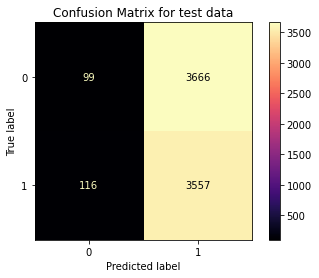

In [ ]:
# Test data
predictions_test = clf_knn_kbest.predict(x_test_kbest)
report_test = classification_report(y_test, predictions_test, target_names=['Negative','Positive'])
print("----------------------Test Data----------------------")
print(report_test)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_test, clf_knn_kbest.predict_proba(x_test_kbest)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_test, clf_knn_kbest.predict_proba(x_test_kbest)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_test, clf_knn_kbest.predict(x_test_kbest))), '\n')

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(clf_knn_kbest, x_test_kbest, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

#### **Dataset (Dimensionality Reduction)**
Then we will use the (Dimensionality reduction) dataset for our classifier.

**Create and Tuning Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import time

model = KNeighborsClassifier()

grid_params = {
'n_neighbors': (3,5)
}

# Train
# Solver -- Algorithm to use in the optimization problem.
clf = RandomizedSearchCV(model, grid_params, scoring='f1', n_jobs=-1, n_iter=50)
start_time = time.time()
clf.fit(x_train_svd, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate in development data
val_score=clf.score(x_dev_svd, y_dev)

print("Validation Score: {:.4f}".format(val_score))
print("Best Score: {:.4f}".format(clf.best_score_),'\n')
print("Best Parameters: ", clf.best_params_)

Training took: 43.3561692237854 seconds 

Validation Score: 0.6556
Best Score: 0.7651 

Best Parameters:  {'n_neighbors': 5}


**Evaluate Classifier**

In [ ]:
# Disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')

### Create classifier that fits in train and development data ###
clf_knn_svd_est = KNeighborsClassifier(**clf.best_params_)
clf_knn_svd = KNeighborsClassifier(**clf.best_params_).fit(x_traindev_svd, y_traindev)

##### Evaluate #####

# Training Data
predictions = clf_knn_svd.predict(x_train_svd)
report_training = classification_report(y_train, predictions, target_names=['Negative','Positive'])
print("--------------------Training Data--------------------")
print(report_training)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_train, clf_knn_svd.predict_proba(x_train_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_train, clf_knn_svd.predict_proba(x_train_svd)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_train, clf_knn_svd.predict(x_train_svd))), '\n')

# Developmnent Data
predictions_dev = clf_knn_svd.predict(x_dev_svd)
report_dev = classification_report(y_dev, predictions_dev, target_names=['Negative','Positive'])
print("-------------------Development Data-------------------")
print(report_dev)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_dev, clf_knn_svd.predict_proba(x_dev_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_dev, clf_knn_svd.predict_proba(x_dev_svd)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_dev, clf_knn_svd.predict(x_dev_svd))), '\n')

--------------------Training Data--------------------
              precision    recall  f1-score   support

    Negative       0.72      0.75      0.74     17300
    Positive       0.75      0.71      0.73     17405

    accuracy                           0.73     34705
   macro avg       0.73      0.73      0.73     34705
weighted avg       0.73      0.73      0.73     34705

PR-AUC score Negative: 0.1980
PR-AUC score Positive: 0.8020 

Macro average PR-AUC score: 0.6751 

-------------------Development Data-------------------
              precision    recall  f1-score   support

    Negative       0.64      0.71      0.67      3633
    Positive       0.69      0.62      0.66      3806

    accuracy                           0.67      7439
   macro avg       0.67      0.67      0.66      7439
weighted avg       0.67      0.67      0.66      7439

PR-AUC score Negative: 0.2752
PR-AUC score Positive: 0.7248 

Macro average PR-AUC score: 0.6240 



**Testing Classifier**

----------------------Test Data----------------------
              precision    recall  f1-score   support

    Negative       0.70      0.75      0.72      3765
    Positive       0.72      0.67      0.69      3673

    accuracy                           0.71      7438
   macro avg       0.71      0.71      0.71      7438
weighted avg       0.71      0.71      0.71      7438

PR-AUC score Negative: 0.2293
PR-AUC score Positive: 0.7707 

Macro average PR-AUC score: 0.6452 



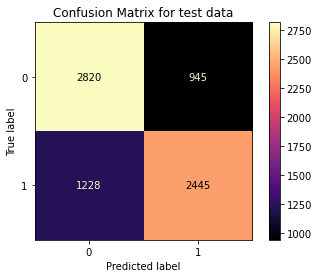

In [ ]:
# Test data
predictions_test = clf_knn_svd.predict(x_test_svd)
report_test = classification_report(y_test, predictions_test, target_names=['Negative','Positive'])
print("----------------------Test Data----------------------")
print(report_test)
print('PR-AUC score Negative: {:.4f}'.format(roc_auc_score(y_test, clf_knn_svd.predict_proba(x_test_svd)[:, 0])))
print('PR-AUC score Positive: {:.4f}'.format(roc_auc_score(y_test, clf_knn_svd.predict_proba(x_test_svd)[:, 1])), '\n')
print('Macro average PR-AUC score: {:.4f}'.format(average_precision_score(y_test, clf_knn_svd.predict(x_test_svd))), '\n')

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(clf_knn_svd, x_test_svd, y_test, values_format = '.0f', cmap = 'magma')
plt.title("Confusion Matrix for test data")
plt.show()

## **Learning Curves**

Finally we will plot the learning curves for our classifiers. For the plotting we will combine the training and development subsets. We will use the SuffleSplit function to perform the cross validation in the combined training-development subset.

The dataset will be from the ***Dimensionality Reduction*** because it gave better estimations in almost all cases. 

**Determine the plot fuction**

In [ ]:
# Learning curves with cross-validation
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, X, y, title, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1_macro', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Development score")

    plt.legend(loc="lower right")
    return plt

**Plots**

<Figure size 720x576 with 0 Axes>

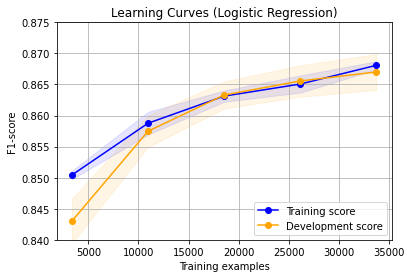

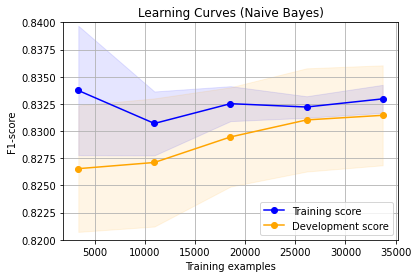

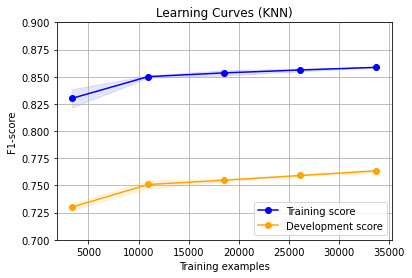

In [ ]:
# Use cross validation with 5 splits, 20% test subset size each time

fig = plt.figure(figsize=(10, 8))

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = clf_lr_svd_est
plot_learning_curve(estimator, x_traindev_svd, y_traindev, title, ylim=(0.84, 0.875), n_jobs=-1)
plt.show()

title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = clf_nb_svd_est
plot_learning_curve(estimator, x_traindev_svd_sc, y_traindev,title, ylim=(0.82, 0.84), cv=cv, n_jobs=-1)
plt.show()

title = "Learning Curves (KNN)"
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
estimator = clf_knn_svd_est
plot_learning_curve(estimator,  x_traindev_svd, y_traindev, title, ylim=(0.7, 0.9), cv=cv, n_jobs=-1)
plt.show()

## **Conclusions**

From the above results we have two main conclusions for the classifiers. 
* The **Dimensionality Reduction (SVD) dataset** performs better in all classifiers.
* The **Logistic Regression classifier** has the better accuracy among them. 

Reganding the Learning Curves. 

* **Logistic Regression:** This is the best of the three classifiers because as the training examples become more, the f1 score increases both for the training set and the validation set and there is no significant gap between the two curves after 15000 examples.
* **Naive Bayes:** For this classifier the performance is also good as there is no significant overfitting or underfitting. However, there is a bigger gap between the two curves which indicates a less powerful classifier.
* **KNN:** In this occasion, we observe underfitting. Thus, our KNN classifier is no complex enough to fit our data and be able to predict new data points.

## **References**

* https://scikit-learn.org/
* https://stackabuse.com/text-classification-with-python-and-scikit-learn/
* https://medium.com/@kocur4d/hyper-parameter-tuning-with-pipelines-5310aff069d6
* https://stackoverflow.com/questions/24169238/dealing-with-negative-values-in-sklearn-multinomialnb
* https://medium.com/analytics-vidhya/the-best-feature-selection-technique-for-text-classification-23199b4a4f8d